# Notes - race and ethnicity


In [1]:
import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from graphviz import Digraph
from sympy.physics.units import magnetic_density

from variables import Variables as vars

plt.style.use('../../notebook.mplstyle')

In [2]:
# df = pd.read_parquet("./data/us_births.parquet")
con = duckdb.connect("./data/us_births.db", read_only=True)

In [3]:
race_df = con.execute(
    """
    SELECT
        year, COUNT (*) AS ALL, COUNT (mrace) AS mrace, COUNT (mracerec) AS mracerec, COUNT (mraceimp) AS mraceimp, COUNT (mbrace) AS mbrace, COUNT (mrace31) AS mrace31, COUNT (mrace6) AS mrace6, COUNT (mrace15) AS mrace15, COUNT (umhisp) AS umhisp, COUNT (mhispx) AS mhispx, COUNT (mhisp_r) AS mhisp_r, COUNT (mracehisp) AS mracehisp, count (orracem) as orracem
    FROM
        us_births
    WHERE
        YEAR >= 1989
      AND restatus <> 4
    GROUP BY YEAR
    ORDER BY YEAR
    """
).df()
race_df

,year,ALL,mrace,mracerec,mraceimp,mbrace,mrace31,mrace6,mrace15,umhisp,mhispx,mhisp_r,mracehisp,orracem
0,1989,4040958,4040958,0,14773,0,0,0,0,0,0,0,0,4040958
1,1990,4158212,4158212,0,12613,0,0,0,0,0,0,0,0,4158212
2,1991,4110907,4110907,0,12875,0,0,0,0,0,0,0,0,4110907
3,1992,4065014,4065014,0,16159,0,0,0,0,0,0,0,0,4065014
4,1993,4000240,4000240,0,17743,0,0,0,0,0,0,0,0,4000240
5,1994,3952767,3952767,0,21708,0,0,0,0,0,0,0,0,3952767
6,1995,3899589,3899589,0,23446,0,0,0,0,0,0,0,0,3899589
7,1996,3891494,3891494,0,27430,0,0,0,0,0,0,0,0,3891494
8,1997,3880894,3880894,0,27905,0,0,0,0,0,0,0,0,3880894
9,1998,3941553,3941553,0,28608,0,0,0,0,0,0,0,0,3941553


Race variables include:


#### `MRACE` (1989-2013, though declining from 2003)

```
01 White
02 Black
03 American Indian / Alaskan Native
04 Chinese
05 Japanese
06 Hawaiian (includes part Hawaiian)
07 Filipino
18 Asian Indian
28 Korean
38 Samoan
48 Vietnamese
58 Guamanian
68 Other Asian / Pacific Islander in areas reporting codes 18-58
78 Combined other Asian / Pacific Islander includes 18-68 for areas that do not report them separately
```

#### `MRACEREC` (from 2003-2013)

```
1 White
2 Black
3 American Indian / Alaskan Native
4 Asian / Pacific Islander
```

#### `MBRACE` (2003-2019)

```
1 White
2 Black
3 American Indian or Alaskan Native
4 Asian or Pacific Islander
(Puerto Rico excludes 3 and 4)
```

#### `MRACE15` (from 2014)

```
01 White (only)
02 Black (only)
03 American Indian / Alaskan Native (only)
04 Asian Indian (only)
05 Chinese (only)
06 Filipino (only)
07 Japanese (only)
08 Korean (only)
09 Vietnamese (only)
10 Other Asian (only)
11 Hawaiian (only)
12 Guamanian (only)
13 Samoan (only)
14 Other Pacific Islander (only)
15 More than one race
```

#### `MRACE6` (from 2018) - can be derived from `MRACE15`

```
1 White (only)
2 Black (only)
3 American Indian / Alaskan Native (only)
4 Asian (only)
5 Native Hawaiian or Other Pacific Islander (only)
6 More than one race
```

We combine as follows to get back to 1989:

```
MRACE_C (combined)
1 White
2 Black
3 American Indian or Alaskan Native
4 Asian or Pacific Islander
```

For 2014 on, we have MRACE15, which is summarised in MRACE6 and where more than one race are broken out in MRACE31.

We set `mrace_c` as follows:

- if `mrace15` is available, use `mrace6`, 1:1, 2:2, 3:3, 4-14:4, otherwise,
- if `mracerec` is available, use `mracerec`, 1:1, 2:2, 3:3, 4:4, otherwise,
- if `mbrace` is available, use `mbrace`, 1:1, 2:2, 3:3, 4:4, otherwise,
- if `mrace` is available, use `mrace`, 1:1, 2:2, 3:3, 4-78:4, otherwise,
- missing.


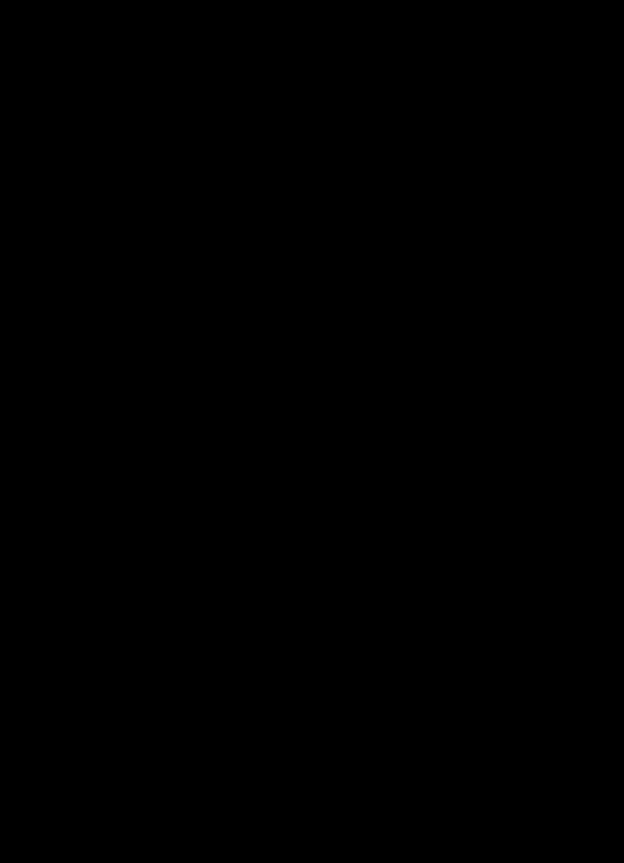

In [15]:
mrace_c_df = con.execute(
    f"""
    SELECT
        {vars.YEAR},
        {vars.MAGE_C},
        {vars.MRACE},
        {vars.MRACEREC},
        {vars.MBRACE},
        {vars.MRACE15},
        {vars.MRACE6},
        {vars.DOWN_IND}
    FROM
        us_births
    """
).df().set_index(vars.YEAR)

mrace_c_df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,mage_c,mrace,mracerec,mbrace,mrace15,mrace6,down_ind
year,,,,,,,
1989,15,2,<NA>,None,<NA>,<NA>,0
1989,22,3,<NA>,None,<NA>,<NA>,0
1989,26,1,<NA>,None,<NA>,<NA>,0
1989,20,2,<NA>,None,<NA>,<NA>,0
1989,32,2,<NA>,None,<NA>,<NA>,0
...,...,...,...,...,...,...,...
2024,23,<NA>,<NA>,None,1,1,0
2024,29,<NA>,<NA>,None,1,1,0
2024,29,<NA>,<NA>,None,1,1,0


<Axes: xlabel='year'>

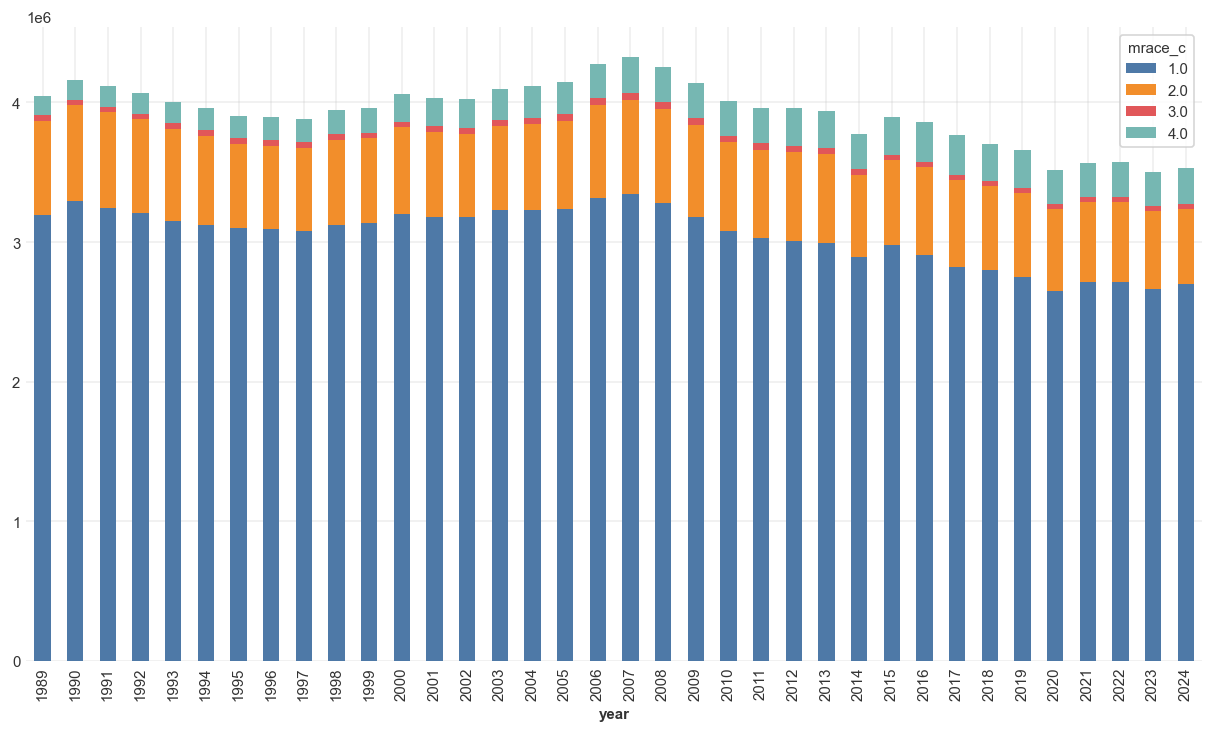

In [13]:
# plot grouped_df as a stacked bar chart
grouped_df_unstacked = grouped_df.unstack().fillna(0)
grouped_df_unstacked.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    color=["#4E79A7", "#F28E2B", "#E15759", "#76B7B2"],
)

For Hispanic, we have:

MRACEHISP (from 2003)

```
1 Non-Hispanic White (only)
2 Non-Hispanic Black (only)
3 Non-Hispanic AIAN (only)
4 Non-Hispanic Asian (only)
5 Non-Hispanic NHOPI (only)
6 Non-Hispanic more than one race
7 Hispanic
8 Origin unknown or not stated
```

UMHISP (2003-2013) - slightly better counts than MRACEHISP

```
0 Non-Hispanic
1 Mexican
2 Puerto Rican
3 Cuban
4 Central American
5 Other and Unknown Hispanic
9 Origin unknown or not stated
```

ORRACEM (from 1989-2002)

```
1 Mexican
2 Puerto Rican
3 Cuban
4 Central or South American
5 Other and unknown Hispanic
6 Non-Hispanic White
7 Non-Hispanic Black
8 Non-Hispanic other races
9 Origin unknown or not stated
```

MHISP_R (from 2014)

```
0 Non-Hispanic
1 Mexican
2 Puerto Rican
3 Cuban
4 Central and South American
5 Other and Unknown Hispanic origin
9 Hispanic origin not stated
```

MHISPX (from 2018)

```
0 Non-Hispanic
1 Mexican
2 Puerto Rican
3 Cuban
4 Central or South American
5 Dominican
6 Other and Unknown Hispanic
9 Origin unknown or not stated
```

We merge to:

MHISP_C

```
0 Non-Hispanic
1 Mexican
2 Puerto Rican
3 Cuban
4 Other and Unknown Hispanic
5 Origin unknown or not stated
```

Rules:

- if `mhispx` is available, then 0:0, 1:1, 2:2, 3:3, 4-6:4, 9:5, otherwise
- if `mhisp_r` is available, then 0:0, 1:1, 2:2, 3:3, 4-5:4, 9:5, otherwise
- if `umhisp` is available, then 0:0, 1:1, 2:2, 3:3, 4-5:4, 9:5, otherwise
- if `orracem` is available, then 6-8:0, 1:1, 2:2, 3:3, 4-5:4, 9:5, otherwise
- missing

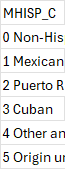